# This code is to apply Genetic Algorithm optimization for the input of the CFD dataset for both cases, Fluidized and Fixed Beds

## The Objective functions are extracted from trained NN from Part 1 ....

### Note: track the word "change" for to change the variables according to your problem

# 1. Library Imports

In [1]:
# !{sys.executable} -m pip install pygad ## pygas installation

In [2]:
import pygad
import numpy as np  
import pandas as pd 
import torch 

In [3]:
## Suppress All Warnings (Use With Caution)
import warnings
warnings.filterwarnings("ignore")

## Output File Names (change name according to your needs)

In [4]:
filename_fixed = 'GA_H2_3inputs_Fixed__'     ######## change / name of the file .pkl for the GA results Fixed case ###########
filename_fluid = 'GA_H2_3inputs_Fluidized__'   ########## change / name of the file .pkl for the GA results fluidized case ###########

## Models Names (Change according to your trained models from ANN)

In [5]:
model_output_Fixed = 'model_NewInputs_H2_4.pt'  ###### change  / Name of the model to optimize for the Fixed bed case ######### 
model_output_Fluidized = 'model_NewInputs_H2_4.pt'     ######## change / Name of the model to optimize for the Fluidized bed case #########

# 2. A. Define the NN Model (for loading) and Training Dataset (for StandardScaler() fit)

In [6]:
data = pd.read_excel(open('Data_ML_Final.xlsx', 'rb'),sheet_name='Final_Data') 
df_inputs = data.drop(['Fixed', 'CO2', 'CH4', 'X_CH4', 'X_CO2', 'Y_H2', 'Y_CO', 'C_c'], axis=1) # dropping the output columns
df_inputs.head() # check if output columns were dropped

,Fluidized,Bed Height (m),Superficial Velocity (m/s),MFR
0,0,2.85,0.9,1.0
1,0,2.85,1.1,1.0
2,0,2.85,1.3,1.0
3,0,2.85,1.5,1.0
4,1,2.85,0.9,1.0


In [7]:
## Define Output Matrics
y_CH4 = data['X_CH4']
y_CO2 = data['X_CO2']
y_H2 = data['Y_H2']
y_CO = data['Y_CO']
y_C_c = data['C_c']

## Change y_output from the above list according to the output to optimize

y_output = y_H2  ### used in the StandardScaler() function

In [8]:
from sklearn.model_selection import train_test_split

## Data Set Split (60/20/20)
X_trainval_CH4_O, X_test_CH4_O, y_trainval_CH4_O, y_test_CH4_O = train_test_split(df_inputs, y_output,test_size=0.2,train_size=0.8, random_state=42)
X_train_CH4_O, X_valid_CH4_O, y_train_CH4_O, y_valid_CH4_O = train_test_split(X_trainval_CH4_O,y_trainval_CH4_O,test_size = 0.25,train_size =0.75, random_state=42)

In [9]:
X_trainval_CH4_O

,Fluidized,Bed Height (m),Superficial Velocity (m/s),MFR
28,1,2.280,0.9,2.333333
24,1,2.280,1.3,1.000000
12,1,2.850,0.9,1.500000
0,0,2.850,0.9,1.000000
4,1,2.850,0.9,1.000000
16,1,2.565,1.3,1.000000
5,1,2.850,1.1,1.000000
13,1,2.850,0.9,2.333333
11,1,2.850,0.9,0.666667
22,1,2.280,0.9,1.000000


In [10]:
from sklearn.preprocessing import StandardScaler

## SCALE (S) DATA
scaler = StandardScaler()
scaler.fit(X_train_CH4_O)
X_train_CH4_S = scaler.transform(X_train_CH4_O)
X_valid_CH4_S = scaler.transform(X_valid_CH4_O)
X_test_CH4_S = scaler.transform(X_test_CH4_O)

In [11]:
## Transformation (T) for the pytorch library
X_train_CH4_T = torch.from_numpy(X_train_CH4_S).float()
y_train_CH4_T = torch.from_numpy(y_train_CH4_O.values.reshape(-1,1)).float()
    
X_valid_CH4_T = torch.from_numpy(X_valid_CH4_S).float()
y_valid_CH4_T = torch.from_numpy(y_valid_CH4_O.values.reshape(-1,1)).float()
    
X_test_CH4_T = torch.tensor(X_test_CH4_S).float()
y_test_CH4_T = torch.tensor(y_test_CH4_O.values.reshape(-1,1)).view(-1, 1).float()

### Note: The model class (used to traing the model) must be included in the code here for the model to be loaded

In [12]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, trial, nfeatures, ntargets, nlayers, dropout, activation_func):
        super().__init__()
        layers = []
        out_features_list = [24,10]  ###### change according to the optimized NN model number of nodes (for each layer) ######## For H2
        for _ in range(nlayers):
            out_features = out_features_list[_]   ### changed since already optimzied ### out_features = trial.suggest_int("n_units_l{}".format(_), 1, 30)
            layers.append(nn.Linear(nfeatures, out_features)) 
            layers.append(nn.Dropout(dropout))
            layers.append(getattr(nn, activation_func)() )
            nfeatures = out_features
        layers.append(nn.Linear(nfeatures, ntargets))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)    

## 2. B. Define the neural network as the fitness function

### Define Input (with SV, MFR and BH as variable parameters) 

### For Case 1. Fixed

In [13]:
def fitness_func(ga_instance, solution, solution_idx):
    
    ## Take the SV value then convert it (with other input parameters) to a DataFrame
    series_SV = pd.Series([0,solution[2],solution[0],solution[1]], index=['Fluidized', 'Bed Height (m)', 'Superficial Velocity (m/s)', 'MFR'])

    df_SV_O = pd.DataFrame([series_SV])
   
    ## SCALE (S) DATA
    df_SV_S = scaler.transform(df_SV_O)

    ## Transformation (T) for the pytorch library
    df_SV_T = torch.from_numpy(df_SV_S).float()

### For output NN model

    ## Load Trained NN Model
    model_test = torch.load(model_output_Fixed)   ### model of the output to optimize

    ## Predict the X_output (X_H2 as an example) for different SV values (Using the previously Trained NN model) 
    model_test.eval()
    predictions_test = model_test(df_SV_T).detach().numpy()
    
    fitness1 = np.float64(predictions_test[0]) 
    
    return [fitness1] # fitness

# 3. Prepare the parameters of PyGAD. 

### Note: change (num_genes & gene_space) according to the number of inputs to optimize and their range: 

In [14]:
fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4
sol_per_pop = 8
init_range_low = [0.9, 0.24, 2.28]     ## Initial guess
init_range_high = [1.5, 0.42, 2.85]
parent_selection_type = "sss"
keep_parents = 1   
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10

### Define the lower and upper bounds of the solution parameters, must equal to the "num_genes"
num_genes = 3    ### Number of optimized parameters    ############ change according to problem 
gene_space = [np.linspace(0.9, 1.5), np.linspace(0.666667, 2.333333), np.linspace(2.28, 2.85)]  ## Range of Superficial Velocity (m/s) [0] in the Dataset and MFR [1] and Bed Height (m) [2]

# 4. Instance of the pygad.GA class is created.

In [15]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space=gene_space)

# 5. The run() method is called to start the optimization.

In [16]:
ga_instance.run()

# 6.  information about the best solution found by PyGAD can be accessed.

In [17]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print(f"Parameters of the best solution : {solution}")
print(f"Fitness value of the best solution = {solution_fitness}")

Parameters of the best solution : [0.9        2.333333   2.83836735]
Fitness value of the best solution = [0.04511461]


In [18]:
ga_instance.best_solution() # information about the best solution in the last population is returned

(array([0.9       , 2.333333  , 2.83836735]), array([0.04511461]), 0)

# 7. Plotting Results

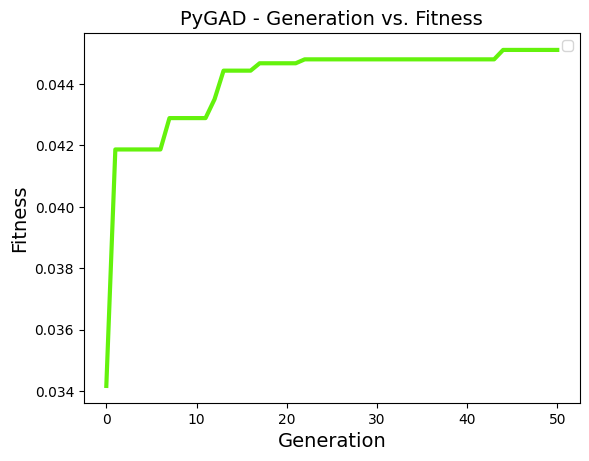

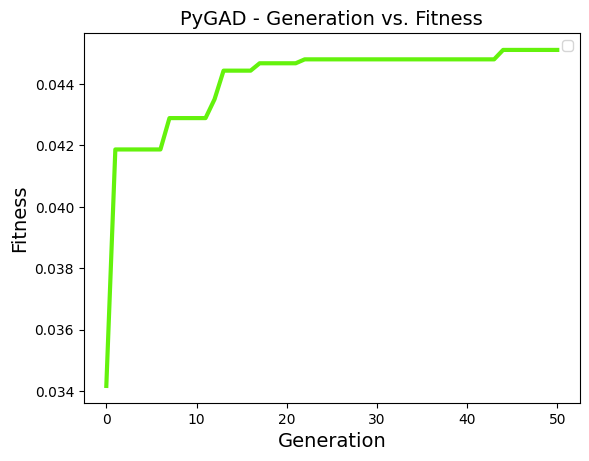

In [19]:
ga_instance.plot_fitness()

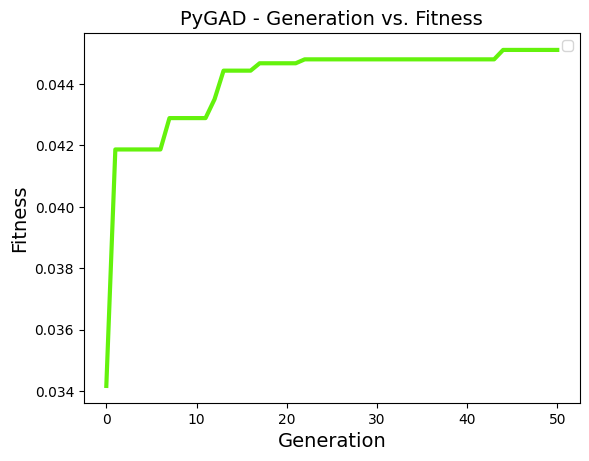

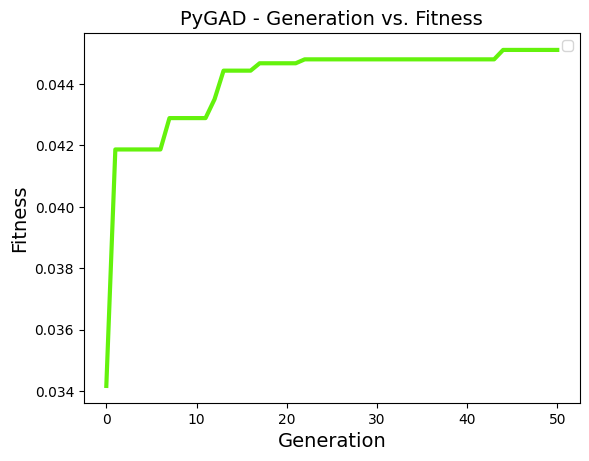

In [20]:
ga_instance.plot_fitness(label=['H2'])    ##### change Label according to output ######

# 8. Saving & Loading the Results

In [21]:
# According to the next code, a file named genetic_NN.pkl will be created and saved in the current directory.
ga_instance.save(filename=filename_fixed) 

In [22]:
# load the model using the load() function, and then call the run() method again.
loaded_ga_instance = pygad.load(filename=filename_fixed)

In [23]:
# After the instance is loaded, you can use it to run any method or access any property.
print(loaded_ga_instance.best_solution())

(array([0.9       , 2.333333  , 2.83836735]), array([0.04511461]), 0)


# For Case 2. Fluidized

### Define Input (with SV, MFR and BH as variable parameters) 

In [24]:
def fitness_func_Fluidized(ga_instance, solution, solution_idx):
    
    ## Take the SV value then convert it (with other input parameters) to a DataFrame
    series_SV = pd.Series([1,solution[2],solution[0],solution[1]], index=['Fluidized', 'Bed Height (m)', 'Superficial Velocity (m/s)', 'MFR'])
    #     solution[0]: Superficial Velocity (m/s)
    #     solution[1]: MFR
    #     solution[2]: Bed Height (m)
    df_SV_O = pd.DataFrame([series_SV])
   
    ## SCALE (S) DATA
    df_SV_S = scaler.transform(df_SV_O)

    ## Transformation (T) for the pytorch library
    df_SV_T = torch.from_numpy(df_SV_S).float()

### For output NN model

    ## Load Trained NN Model
    model_test = torch.load(model_output_Fluidized)      ### model of the output to optimize

    ## Predict the X_output (i.e. X_CH4, X_H2) for different SV values (Using the previously Trained NN model) 
    model_test.eval()
    predictions_test = model_test(df_SV_T).detach().numpy()
    fitness1 = np.float64(predictions_test[0])

    return [fitness1] 

In [25]:
ga_instance_fluid = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func_Fluidized,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space=gene_space)

In [26]:
ga_instance_fluid.run()

## Information about the best solution

In [27]:
solution_fluid, solution_fitness_fluid, solution_idx_fluid = ga_instance_fluid.best_solution()

print(f"Parameters of the best solution : {solution_fluid}")
print(f"Fitness value of the best solution = {solution_fitness_fluid}")

Parameters of the best solution : [0.9        2.333333   2.83836735]
Fitness value of the best solution = [0.0970158]


### Plotting Results

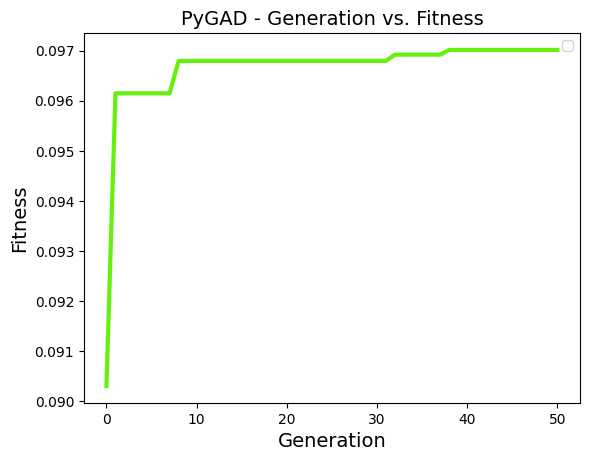

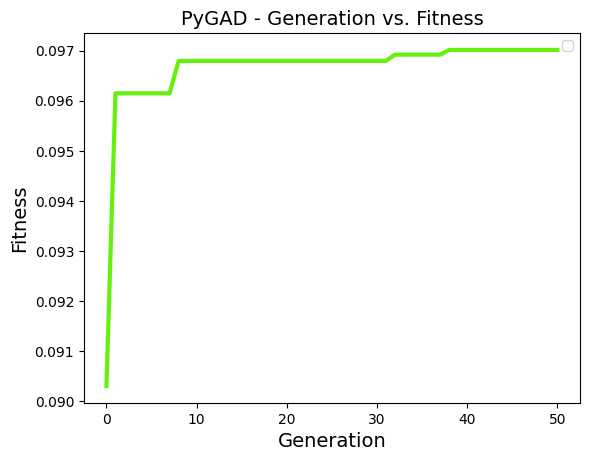

In [28]:
ga_instance_fluid.plot_fitness(label=['H2']) ##### change Label according to output ######

### Saving & Loading the Results

In [29]:
# According to the next code, a file named genetic_NN.pkl will be created and saved in the current directory.
ga_instance_fluid.save(filename=filename_fluid)

In [30]:
# load the model using the load() function, and then call the run() method again.
loaded_ga_instance_fluid = pygad.load(filename=filename_fluid)

In [31]:
# After the instance is loaded, you can use it to run any method or access any property.
print(loaded_ga_instance_fluid.best_solution())

(array([0.9       , 2.333333  , 2.83836735]), array([0.0970158]), 0)
